# U-Net for Mitochondria Segmentation

---
## Introduction
This is a notebook that shows how to design and train a [U-Net](https://en.wikipedia.org/wiki/U-Net)-like network to predict the instance masks of individual mitochondrion from the large-scale MitoEM dataset released by [Wei et al. in 2020](https://donglaiw.github.io/page/mitoEM/index.html).

**Authors**: [Hanspeter Pfister](https://vcg.seas.harvard.edu/people/hanspeter-pfister), [Jeff W. Lichtman](https://lichtmanlab.fas.harvard.edu/people/jeff-lichtman), [Ignacio Arganda-Carreras](https://sites.google.com/site/iargandacarreras/), [Donglai Wei](https://donglaiw.github.io/), [Xueying Wang](https://scholar.google.es/citations?user=QJNjdxwAAAAJ&hl=es&oi=ao), [Won-Dong Jang](https://wdjang.github.io/), [Zudi Lin](https://zudi-lin.github.io/), [Daniel Franco-Barranco](https://danifranco.github.io) and Wenjie Yin.



## Dataset introduction

Insert here the explanation of the dataset, maybe the same one as the posted in the challenge page

# 0. Initialization

## 0.1. Importing requirements

In [2]:
#@markdown ##Run this cell to check if you have GPU access
%tensorflow_version 2.1

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print("You do not have GPU access.") 
  print("Did you change your runtime ?") 
  print("If the runtime setting is correct then Google did not allocate a GPU for your session")
  print("Expect slow performance. To access GPU try reconnecting later")

else:
  print("You have GPU access")
  !nvidia-smi

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
You have GPU access
Wed Oct 21 11:15:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-

In [3]:
import os
import numpy as np
from tqdm import tqdm                                                           
from sklearn.model_selection import train_test_split                            
from skimage.io import imread                                                   
from matplotlib import pyplot as plt


## 0.2. Downloading the data

### 0.2.1. Original version


Next, we download the ZIP file with the image data and unzip it in Google's content. 

In [4]:
#import zipfile
#
## Download file with image data
#!wget 'http://rhoana.rc.fas.harvard.edu/dataset/mitoEM/mitoEM-H_im.zip'
#path2zip= 'mitoEM-H_im.zip'
#
## Extract locally
#with zipfile.ZipFile(path2zip, 'r') as zip_ref:
#    zip_ref.extractall('/content/dataset/')
#
#train_path = '/content/gdrive/My Drive/Universidad/Thesis/Thesis/Grand challenge - MitoEM/MitoEM_dataset/human/im'
#train_mask_path = '/content/gdrive/My Drive/Universidad/Thesis/Thesis/Grand challenge - MitoEM/MitoEM_dataset/human/mito'
img_train_shape = (4096, 4096, 1)


### 0.2.2. Drive version (just to test)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
train_path = '/content/gdrive/My Drive/Universidad/Thesis/Thesis/Grand_challenge_MitoEM/MitoEM_dataset/human/im'
train_mask_path = '/content/gdrive/My Drive/Universidad/Thesis/Thesis/Grand_challenge_MitoEM/MitoEM_dataset/human/mito'
img_train_shape = (4096, 4096, 1)


Mounted at /content/gdrive


# 1. Preparing the data 

## 1.1 Load data

### Define the read function 

In [6]:
def load_data_from_dir(data_dir, shape):                                        
    """Load data from a directory.                                              
                                                                                
    Parameters                                                                  
    ----------                                                                  
    data_dir : str                                                              
        path to read the data from.                                             
                                                                                
    shape : 3D int tuple                                                        
        shape of the data.                                                      
                                                                                
    Returns                                                                     
    -------                                                                     
    data : 4D Numpy array                                                       
        data loaded. E.g. ``(image_number, x, y, channels)``.                   
    """                                                                        
    print("Loading data from {}".format(data_dir))                              
    ids = sorted(next(os.walk(data_dir))[2])                                    
    data = np.zeros((len(ids), ) + shape, dtype=np.float32)                     
                                                                              
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):                         
        img = imread(os.path.join(data_dir, id_))                               
                                                                                                                                          
        if len(img.shape) == 2:                                                 
            img = np.expand_dims(img, axis=-1)                                  
                                                                                
        data[n] = img                                                                                                                                           
    return data        

Load training/validation data. We should be able to read the list of **500 training images** together with their corresponding binary masks.

In [7]:
X_train = load_data_from_dir(train_path, img_train_shape)
Y_train = load_data_from_dir(train_mask_path, img_train_shape)

print("Number of training input images: {}".format(X_train.shape[0]))
print("Number of training binary mask images: {}".format(Y_train.shape[0]))

Loading data from /content/gdrive/My Drive/Universidad/Thesis/Thesis/Grand_challenge_MitoEM/MitoEM_dataset/human/im


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Loading data from /content/gdrive/My Drive/Universidad/Thesis/Thesis/Grand_challenge_MitoEM/MitoEM_dataset/human/mito


100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

Number of training input images: 6
Number of training binary mask images: 6


Next, we read all those images into memory and display one with its corresponding labels (masks and countours).


Text(0.5, 1.0, 'Binary mask')

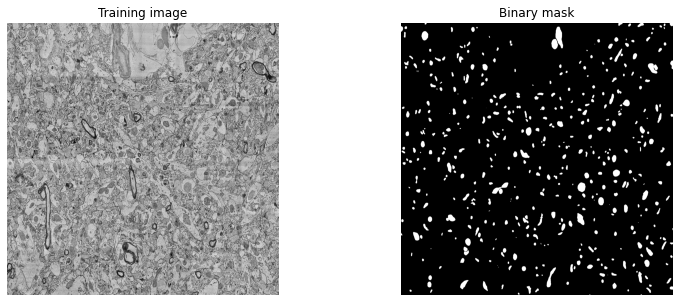

In [8]:
# Display the image
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.imshow( X_train[0,...,0], "gray")
plt.axis("off")
plt.title("Training image")
# its "mask"
plt.subplot(1, 3, 2)
plt.imshow(Y_train[0,...,0], "gray")
plt.axis("off")
plt.title("Binary mask")


## 1.2 Create valiation data 

Next, we reserve 10% of the training data for validation. 

In [9]:
X_train, X_val, \
    Y_train, Y_val = train_test_split(
        X_train, Y_train, test_size=0.1, shuffle=True)

print("The training data shape is: {}".format(X_train.shape))
print("The validation data shape is: {}".format(X_val.shape))

The training data shape is: (5, 4096, 4096, 1)
The validation data shape is: (1, 4096, 4096, 1)


## 1.3 Cropping the data

Now, we are going to create the training set by cropping the input images (and their corresponding labels) into **patches of 256 x 256 pixels**.

### Define crop function

In [10]:
def crop_data(data, crop_shape, data_mask=None, force_shape=(0, 0)):                          
    """Crop data into smaller pieces.
                                                                        
       Parameters
       ----------                                                            
       data : 4D Numpy array
           Data to crop.  E.g. ``(image_number, x, y, channels)``.

       crop_shape : 3D int tuple
           Output image shape. E.g. ``(x, y, channels)``.

       data_mask : 4D Numpy array, optional
           Data masks to crop. E.g. ``(image_number, x, y, channels)``.

       force_shape : 2D int tuple, optional
           Force horizontal and vertical crops to the given numbers.
                                                                        
       Returns
       -------                                                         
       cropped_data : 4D Numpy array
           Cropped data images.         

       cropped_data_mask : 4D Numpy array
           Cropped data masks.     

       force_shape : 2D int tuple
           Number of horizontal and vertical crops made. Useful for future crop 
           calls. 
    """                                                                 

    print("Cropping [{},{}] images into {} . . .".format(data.shape[1], \
          data.shape[2], crop_shape)) 
  
    # Calculate the number of images to be generated                    
    if force_shape == (0, 0):
        h_num = int(data.shape[1] / crop_shape[0]) + (data.shape[1] % crop_shape[0] > 0)
        v_num = int(data.shape[2] / crop_shape[1]) + (data.shape[2] % crop_shape[1] > 0)
        force_shape = (h_num, v_num)
    else:
        h_num = force_shape[0]
        v_num = force_shape[1]
        print("Force crops to [{}, {}]".format(h_num, v_num))

    total_cropped = data.shape[0]*h_num*v_num    

    # Resize data to adjust to a value divisible by height and width
    r_data = np.zeros((data.shape[0], h_num*crop_shape[1], v_num*crop_shape[0], 
                       data.shape[3]), dtype=np.float32)    
    r_data[:data.shape[0],:data.shape[1],:data.shape[2],:data.shape[3]] = data
    if data_mask is not None:
        r_data_mask = np.zeros((data_mask.shape[0], h_num*crop_shape[1], 
                                v_num*crop_shape[0], data_mask.shape[3]), 
                               dtype=np.float32)
        r_data_mask[:data_mask.shape[0],:data_mask.shape[1],
                    :data_mask.shape[2],:data_mask.shape[3]] = data_mask
    if data.shape != r_data.shape:
        print("Resized data from {} to {} to be divisible by the shape provided"\
              .format(data.shape, r_data.shape))

    # Crop data                                                         
    cropped_data = np.zeros((total_cropped, crop_shape[1], 
                              crop_shape[0], r_data.shape[3]), dtype=np.float32)
    if data_mask is not None:
        cropped_data_mask = np.zeros((total_cropped, crop_shape[1], 
                                       crop_shape[0], r_data_mask.shape[3]), 
                                     dtype=np.float32)
    
    cont = 0                                                              
    l_i = 0
    print("1) Cropping images . . .")
    for img_num in tqdm(range(0, r_data.shape[0])): 
        for i in range(0, h_num):                                       
            for j in range(0, v_num):                     
                if data_mask is not None:
                    cropped_data[l_i] = r_data[
                        img_num, (i*crop_shape[0]):((i+1)*crop_shape[1]), 
                        (j*crop_shape[0]):((j+1)*crop_shape[1]),:]

                    cropped_data_mask[l_i] = r_data_mask[
                        img_num, (i*crop_shape[0]):((i+1)*crop_shape[1]),
                        (j*crop_shape[0]):((j+1)*crop_shape[1]),:]

                    l_i = l_i + 1
                else: 
              
                    cropped_data[cont] = r_data[
                        img_num, (i*crop_shape[0]):((i+1)*crop_shape[1]),      
                        (j*crop_shape[0]):((j+1)*crop_shape[1]),:]
                                                                        
                    if data_mask is not None:
                        cropped_data_mask[cont] = r_data_mask[
                            img_num, (i*crop_shape[0]):((i+1)*crop_shape[1]),
                            (j*crop_shape[0]):((j+1)*crop_shape[1]),:]
                cont = cont + 1                                             
                                                                        
    print("**** New data shape is: {}".format(cropped_data.shape))
    print("### END CROP ###")

    if data_mask is not None:
        return cropped_data, cropped_data_mask, force_shape
    else:
        return cropped_data, force_shape

Finally, crop the training and the validation data into patches of the selected shape. 

In [11]:
crop_shape = (256, 256, 1)

X_train, Y_train, _ = crop_data(X_train, crop_shape, data_mask=Y_train)
X_val, Y_val, _ = crop_data(X_val, crop_shape, data_mask=Y_val)

print("The training data shape after cropping is : {}".format(X_train.shape))
print("The validation data shape after cropping is: {}".format(X_val.shape))

Cropping [4096,4096] images into (256, 256, 1) . . .


100%|██████████| 5/5 [00:00<00:00, 28.21it/s]

1) Cropping images . . .
**** New data shape is: (1280, 256, 256, 1)
### END CROP ###
Cropping [4096,4096] images into (256, 256, 1) . . .



100%|██████████| 1/1 [00:00<00:00, 30.57it/s]

1) Cropping images . . .
**** New data shape is: (256, 256, 256, 1)
### END CROP ###
The training data shape after cropping is : (1280, 256, 256, 1)
The validation data shape after cropping is: (256, 256, 256, 1)


# 2. Defining the network

# 3. Training process

# 4. Inference

# 5. Evaluation

When the evaluation container is prepared I will create a guide to make the evaluation correctly. So here the same information as in the grand-challnege page should be posted.